# **SPAM vs. naiwny klasyfikator Bayesa**

## Wprowadzenie
Nigeryjski książę wciąż zarabia na użytkownikach elektronicznych skrzynek pocztowych ponad 700 tys. dolarów rocznie ([źródło](https://www.cnbc.com/2019/04/18/nigerian-prince-scams-still-rake-in-over-700000-dollars-a-year.html))! Jak to możliwe?

Pierwsza przyczyna jest natury psychologicznej. Ofiary są poddawane "perfekcyjnej burzy pokuszeń", jak ujął to psycholog w wywiadzie, do którego linka dałam Wam powyżej. Spammerzy łączą granie na ludzkiej chciwości, ale także na pragnieniu bycia bohaterem. W końcu kto nie chciałby zarobić na byciu wspaniałomyślnym i szczodrym? W tej kwestii możemy pracować wyłącznie nad sobą.

Możemy za to pracować nad filtrami antyspamowymi. Użyjemy techniki, która nazywa się "worek ze słowami" (bag of words) w połączeniu z naiwnym klasyfikatorem Bayesa. Choć to prosty klasyfikator, z powodzeniem jest używany współcześnie (np. [SpamAssassin](https://cwiki.apache.org/confluence/display/spamassassin/BayesInSpamAssassin)).

Notebook oparty na tutorialach:
*   https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73
*   https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored

## Import danych treningowych
https://www.kaggle.com/uciml/sms-spam-collection-dataset

To dane przygotowane przez Almeida et al. na podstawie forum brytyjskiego, gdzie użytkownicy skarżą się na spamowe SMSy. Każdy wiersz składa się z kolumny opisującej czy wiadomość jest spamem, czy nie ('spam' czy 'ham'), a druga zawiera treść wiadomości.

In [2]:
url = "http://studenci.fuw.edu.pl/~akalinow/spam.csv"
df = pd.read_csv(url, encoding="latin-1")
print(df)

        v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  


Dane zawierają zbyteczne kolumny. 

**Proszę**:
* usunąć kolumny zawierające wartości "NaN"
* zmienić nazwy kolumn ```v1``` i ```v2``` na ```label```, oraz ```text```
* sprawdzić jakie wartości etykiet występują w danych - np. narysować histogram dla kolumny ```label```

**Wskazówka**: proszę użyć metod ```DataFrame.dropna()``` oraz ```DataFrame.rename()```

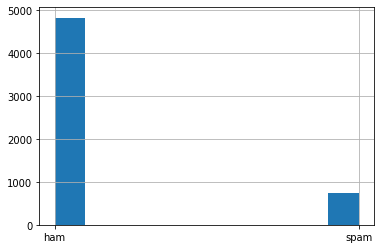

In [3]:
#BEGIN_SOLUTION
df = df.dropna(axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df["label"].hist()
#END_SOLUTION
pass

**Proszę**: 

* wypisać na ekran treść komunikatu o indeksie 57

**Wskazówka**: Indeksy obiektu DataFreame uzyskujemy przez pole ```DataFrame.index```

In [4]:
#BEGIN_SOLUTION
index = 57
print(df[df.index==index])
#END_SOLUTION
pass

   label                                text
57   ham  Sorry, I'll call later in meeting.


## Analiza częstości występowania słów w obu klasach za pomocą biblioteki WordCloud

WordCloud to biblioteka pozwalająca generować śliczne obrazki, na których wielkość słów odpowiada częstości jego występowania w danym zbiorze.

In [5]:
!pip3 install wordcloud
import wordcloud

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1390, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 245, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1368, in render
    renderable = rich_cast(renderable)
  File 

Poniżej kod generujący obrazki dla spamu:

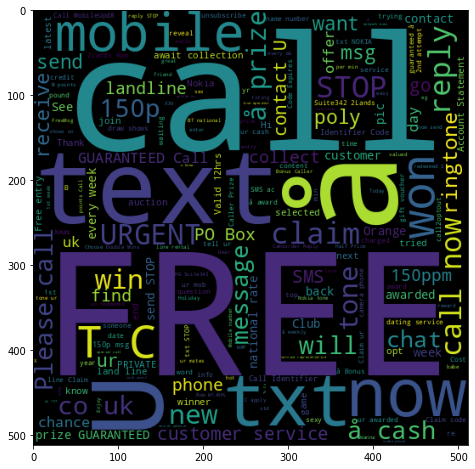

In [6]:
from wordcloud import WordCloud

spam_words = " ".join(list(df [df['label']=='spam']['text'] ))
spam_plot = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize=(10,8))
plt.imshow(spam_plot);

**Proszę**: 

* stworzyć analogiczny obrazek dla klasy ```ham```

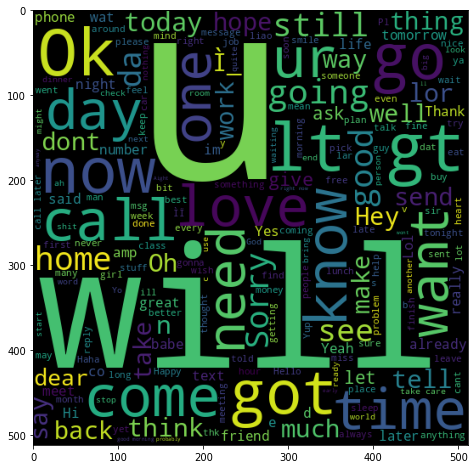

In [7]:
#BEGIN_SOLUTION
ham_words = " ".join(list(df [df['label']=='ham']['text'] ))
ham_plot = WordCloud(width = 512, height = 512).generate(ham_words)
plt.figure(figsize=(10,8))
plt.imshow(ham_plot);
#END_SOLUTION
pass

Dane w tej chwili są w postaci ciągów słów. 
Komórka poniżej zamienia tekst na postać numeryczną używając algorymtu ```CountVectorizer```:

* algorytm tworzy słownik (```vocabulary```) słów przypisując słowom liczbę odpowiadającą jego częstości występowania
  Rozmiary liter i znaki przestankowe są ignorowane
* text jest kodowany w postaci macierzy, gdzie: wiersze odpowiadają poszczególnym zdaniom, kolumny kluczom słownika, elementy macierzy zawierają zliczenia danego klucza.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
text = ["Ala ala ma kota.", "Kot? Kot ma wszy."]
vectorizer = CountVectorizer()
vectorizer.fit(text)
print("Vocabulary:", vectorizer.vocabulary_)
print("Lista słów:", vectorizer.get_feature_names_out())
text_transformed = vectorizer.transform(text)
print("Original text:",text)
print("Transformed text:",text_transformed)
print("Transformed text after decoding",vectorizer.inverse_transform(text_transformed))

Vocabulary: {'ala': 0, 'ma': 3, 'kota': 2, 'kot': 1, 'wszy': 4}
Lista słów: ['ala' 'kot' 'kota' 'ma' 'wszy']
Original text: ['Ala ala ma kota.', 'Kot? Kot ma wszy.']
Transformed text:   (0, 0)	2
  (0, 2)	1
  (0, 3)	1
  (1, 1)	2
  (1, 3)	1
  (1, 4)	1
Transformed text after decoding [array(['ala', 'kota', 'ma'], dtype='<U4'), array(['kot', 'ma', 'wszy'], dtype='<U4')]


**Proszę**:

* przeprowadzić procedurę treningu i transformacji dla danych z e-maili.
* W dokumentacji CountVectorizer znajdź informację o parametrach max_df i min_df. Następnie spróbuj zastosować te parametry. Efekt tych paramatrów działania można sprawdzać za pomocą metody ```vectorizer.stop_words_```.
* wypisać na ekran postać oryginalną i po transformacji maila o indeksie **57**.

In [9]:
#BEGIN_SOLUTION
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(max_df=0.1)
vectorizer.fit(df.text)
data = df.text
idx = 57
text = df[df.index==idx]
text_transformed = vectorizer.transform(df.text)
print("Original text:",df[df.index==idx])
print("Transformed text:",text_transformed[df.index==idx])
print("Transformed text after decoding",vectorizer.inverse_transform(text_transformed[df.index==idx]))
print("Terms that were ignored",vectorizer.stop_words_)
#END_SOLUTION
pass

Original text:    label                                text
57   ham  Sorry, I'll call later in meeting.
Transformed text:   (0, 1812)	1
  (0, 4520)	1
  (0, 4664)	1
  (0, 4954)	1
  (0, 7069)	1
Transformed text after decoding [array(['call', 'later', 'll', 'meeting', 'sorry'], dtype='<U34')]
Terms that were ignored {'the', 'it', 'for', 'and', 'to', 'you', 'me', 'your', 'in', 'is', 'my'}


## Trening klasyfikatora

**Proszę**:
* stworzyć kolumnę ```num_label``` w której ```spam``` będzie oznaczony jako **1**, a ```ham``` jako **0**
* podzielić dane na część treningową i testową w stosunku **7:3**
* wytrenować klasyfikator maili korzystając z naiwnego algorytmu Bayesa opartego o rozkład wielomianowy: ```MultinomialNB```

Oczekiwany wynik:
```Python
Class priors:
 [0.86820513 0.13179487]
```

In [10]:
from sklearn.model_selection import train_test_split
# stwórz nową kolumnę
#BEGIN_SOLUTION
df['num_label'] = df.label == 'spam'
#END_SOLUTION

# Podziel dane na części uczącą i testową
#BEGIN_SOLUTION
X_train, X_test, Y_train, Y_test = train_test_split(text_transformed, df.num_label, test_size=0.3)
#END_SOLUTION

# zaimportuj funkcję MultinomialNB
#BEGIN_SOLUTION
from sklearn.naive_bayes import MultinomialNB
#END_SOLUTION

# stwórz obiekt klasyfikatora
#BEGIN_SOLUTION
model = MultinomialNB()
#END_SOLUTION

# naucz klasyfikator na zbiorze uczącym
#BEGIN_SOLUTION
model.fit(X_train, Y_train);
#END_SOLUTION
pass

print(colored("Class priors:\n","blue"),np.exp(model.class_log_prior_))

Class priors:
 [0.86307692 0.13692308]


## Ocena jakości

**Proszę**: 

* oszacować jakość modelu wybierając samodzielnie metryki, które według Ciebie będą najlepiej sprawdzają czy model poprawnie rozdziela klasy
* odpowiedzieć na pytanie: Jaki ułamek przypadków został poprawnie zaklasyfikowany?
* odpowiedzieć na pytanie: Jaki ułamek dobrych maili został błędnie zaklasyfikowany jako spam?

Oczekiwany wynik:
```Python
MCC: 0.92
ACC: 0.98
FPR: 0.01
```

MCC: 0.91
ACC: 0.98
FPR: 0.01


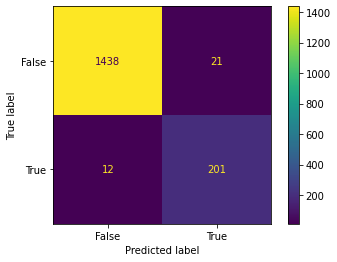

In [11]:
#BEGIN_SOLUTION
from sklearn.metrics import matthews_corrcoef, ConfusionMatrixDisplay
#END_SOLUTION

def printScores(model, X, Y):
    #BEGIN_SOLUTION
    y_pred = model.predict(X)
    ConfusionMatrixDisplay.from_estimator(model, X, Y)
    mcc = matthews_corrcoef(Y, y_pred)
    acc = np.mean(y_pred==Y)
    fpr = np.sum(y_pred*(1-Y))/np.sum(1-Y)
    print(colored("MCC:","blue"),"{:.2f}".format(mcc))
    print(colored("ACC:","blue"),"{:.2f}".format(acc))
    print(colored("FPR:","blue"),"{:.2f}".format(fpr))
    return fpr
    #END_SOLUTION

printScores(model, X_test, Y_test);

## Analiza modelu

Sprawdźmy, czego właściwie maszyna się nauczyła. Analizując współczynniki modelu proszę wskazać słowa które są istotne dla klasyfikacji.

**Proszę**:

* wypisać na ekran informację o liczbie kluczy , "słów" znalezionych w tekście przez ```CountVectorizer```
* wypisać na ekran kształt macierzy parametrów modelu ```MultinomialNB```: ```model.feature_log_prob_```
  i wyjaśnić dlaczego parametry modelu mają właśnie taki kształt
* obliczyć wystąpienia poszczególnych kluczy ("słów") w obu kategoriach
* stworzyć listę zawierającą indeksy posortowanych współczynników: ```np.argsort(...)```
* wypisać na ekran po 10 słów o **największych** wartościach współczynników

**Wskazówki:** 

* by listę słów moć adresować listą indeksów, listę słów trzeba zamienić na macierz numpy.
* indeksy posortowanej macierzy uzyskujemy przez 
```Python
imp = np.argsort(coeff, axis=0)
```
Uwaga: argsort() sortuje w porządku malejącym!

Oczekiwany wynik:
```Python
Liczba kluczy: (8661,)
Kształt macierzy parametrów modelu: (2, 8661)
Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii spam:
['call' 'free' 'or' 'now' 'txt' 'ur' 'on' 'have' 'from' 'stop']
Słowa, które które mają największe prawdopodobioeństwo wystąpienia w kategorii ham:
['that' 'of' 'but' 'can' 'so' 'have' 'are' 'not' 'do' 'on']
```

In [12]:
N = 10

# Stwórz macierz numpy 'feature_names' ze słowami zapisanymi w module vectorizer:
#BEGIN_SOLUTION
feature_names = vectorizer.get_feature_names_out()
feature_names = np.array(feature_names)
print(colored("Liczba kluczy:","blue"),feature_names.shape) 
print(colored("Kształt macierzy parametrów modelu:","blue"),model.feature_log_prob_.shape)
#END_SOLUTION

# Stwórz macierz 'coeff' z prawdopodobieństwami odpowiadającymi słowom z macierzy 'feature_names':
#BEGIN_SOLUTION
coeff = np.exp(model.feature_log_prob_)
#END_SOLUTION

# Znajdź indeksy N najważniejszych słów dla każdej z klas
#BEGIN_SOLUTION
imp_spam = np.argsort(-coeff[1])[:N]
imp_ham = np.argsort(-coeff[0])[:N]
#END_SOLUTION

print(colored("Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii spam:","blue"))
print(feature_names[imp_spam])

print(colored("Słowa, które które mają największe prawdopodobioeństwo wystąpienia w kategorii ham:","blue"))
print(feature_names[imp_ham])

Liczba kluczy: (8661,)
Kształt macierzy parametrów modelu: (2, 8661)
Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii spam:
['call' 'free' 'now' 'or' 'txt' 'on' 'from' 'mobile' 'have' 'ur']
Słowa, które które mają największe prawdopodobioeństwo wystąpienia w kategorii ham:
['that' 'of' 'can' 'but' 'so' 'not' 'have' 'are' 'do' 'at']


## Gdybyście byli spammerami... Co moglibyście zrobić, znając tę technikę antyspamową?

### Stosowanie znaków specjalnych zamiast liter

In [13]:
our_message = vectorizer.transform(['call for free'])
print(colored("Is is spam?","blue"),model.predict(our_message))

our_tricky_message = vectorizer.transform(['c@ll for free'])
print(colored("Is is spam?","blue"),model.predict(our_tricky_message))

Is is spam? [ True]
Is is spam? [False]


### Jakieś inne pomysły? :)

# Praca domowa

Przeprowadź analogiczną analizę dla zbioru tytułów artykułów (https://www.kaggle.com/datasets/algord/fake-news?resource=download) posiadających informację o tym czy dany artykuł jest prawdziwy, "REAL", czy fałszywy "FAKE". Dane znajdują się pod adresem http://studenci.fuw.edu.pl/~akalinow/FakeNewsNet.csv

**Proszę**: 

* narysować "WordCloud" dla obu klas
* wytrenować ```CountVectorizer``` i przeprowadzić transformację tekstu do postaci numerycznej
* wytrenować klasyfikator ```MultinomialNB```
* wypisać metryki dla modelu
* znaleźć 10 słów najczęściej występujących w tekstach obu kategorii
* odpowiedzieć na pytanie:  **Jaki ułamek fałszywych artykułów został oznaczony jako prawdziwe?**

In [14]:
# Wczytywanie danych
#BEGIN_SOLUTION
df = pd.read_csv('http://studenci.fuw.edu.pl/~akalinow/FakeNewsNet.csv')[['title', 'real']]
df = df.rename(columns={'real': 'label', 'title': 'text'})
#END_SOLUTION
df.head()

,text,label
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1


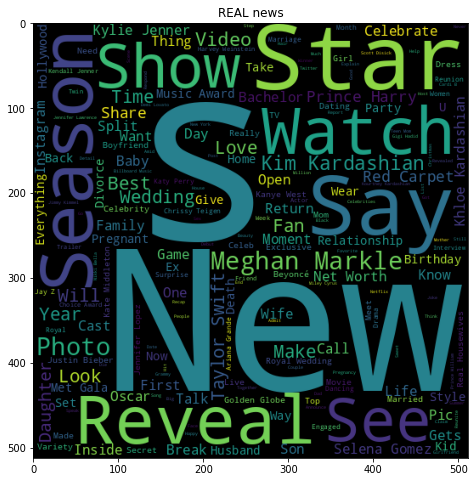

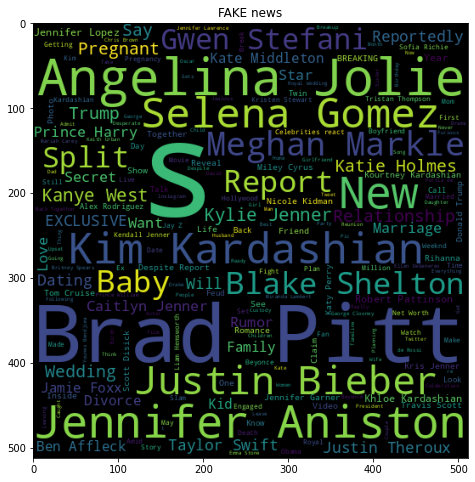

In [15]:
#WordCloud dla obu przypadków
#BEGIN_SOLUTION
real_news_words = " ".join(list(df [df['label']==1]['text'] ))
real_news_plot = WordCloud(width = 512, height = 512).generate(real_news_words)

plt.figure(figsize=(10,8))
plt.imshow(real_news_plot);
plt.title("REAL news")

fake_news_words = " ".join(list(df [df['label']==0]['text'] ))
fake_news_plot = WordCloud(width = 512, height = 512).generate(fake_news_words)

plt.figure(figsize=(10,8))
plt.imshow(fake_news_plot);
plt.title("FAKE news")
#END_SOLUTION
pass

In [16]:
# Trening CountVectorizer i  transformacja.
#BEGIN_SOLUTION
vectorizer = CountVectorizer(min_df=0.001)
vectorizer.fit(df.text)
data = df.text
text = df[df.index==idx]
text_transformed = vectorizer.transform(df.text)
#print("Original text:",df[df.index==idx].values)
#print("Transformed text:",text_transformed[df.index==idx])
#print("Transformed text after decoding",vectorizer.inverse_transform(text_transformed[df.index==idx]))
#print("Terms that were ignored",vectorizer.stop_words_)
#END_SOLUTION
pass

MCC: 0.52
ACC: 0.82
FPR: 0.38
38.00% fałszywych informacji oznaczono jako prawdziwe.


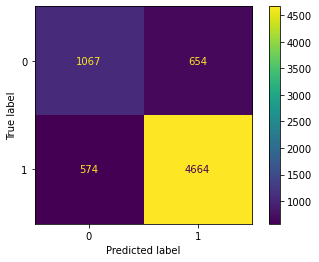

In [17]:
# Podział danych na zbiory treningowy i testowy
#BEGIN_SOLUTION
X_train, X_test, Y_train, Y_test = train_test_split(text_transformed, df.label, test_size=0.3)
#END_SOLUTION

#obiekt klasyfikatora i trening na zbiorze uczącym
#BEGIN_SOLUTION
model = MultinomialNB()
model.fit(X_train, Y_train);
fpr = printScores(model, X_test, Y_test)
#END_SOLUTION
pass

print("{:.2f}%".format(fpr*100), colored("fałszywych informacji oznaczono jako prawdziwe.", "blue"))

In [18]:
#10 najbardziej istotnych słów dla obu klas
#BEGIN_SOLUTION
feature_names = vectorizer.get_feature_names_out()
feature_names = np.array(feature_names)
N = 10
coeff = np.exp(model.feature_log_prob_)
imp_spam = np.argsort(-coeff[1])[:N]
imp_ham = np.argsort(-coeff[0])[:N]

print(colored("Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii REAL:","blue"))
print(feature_names[imp_spam])

print(colored("Słowa, które które mają największe prawdopodobioeństwo wystąpienia w kategorii FAKE:","blue"))
print(feature_names[imp_ham])

#END_SOLUTION
pass

Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii REAL:
['the' 'and' 'to' 'of' 'in' 'on' 'her' 'with' 'for' 'is']
Słowa, które które mają największe prawdopodobioeństwo wystąpienia w kategorii FAKE:
['to' 'and' 'the' 'with' 'is' 'of' 'in' 'on' 'for' 'jennifer']
